In [1]:
#Predicting label image from entire folder #Numpy # x,y,z,depth,intensity

import os
import torch
import numpy as np
from model import Darknet
import time

def process_lidar_intensity(lidar_path, intensity_path, x_path, y_path, z_path, model, device, trial):
    # Load the lidar data (depth)
    lidar = np.load(lidar_path)
    lidar = np.expand_dims(lidar, axis=0)  # Add channel dimension
    lidar = torch.from_numpy(lidar).float().to(device)

    # Load the intensity data
    intensity = np.load(intensity_path)
    intensity = np.expand_dims(intensity, axis=0)  # Add channel dimension
    intensity = torch.from_numpy(intensity).float().to(device)

    # Load the x coordinate data
    x = np.load(x_path)
    x = np.expand_dims(x, axis=0)  # Add channel dimension
    x = torch.from_numpy(x).float().to(device)

    # Load the y coordinate data
    y = np.load(y_path)
    y = np.expand_dims(y, axis=0)  # Add channel dimension
    y = torch.from_numpy(y).float().to(device)

    # Load the z coordinate data
    z = np.load(z_path)
    z = np.expand_dims(z, axis=0)  # Add channel dimension
    z = torch.from_numpy(z).float().to(device)

    # Concatenate the lidar (depth), intensity, x, y, and z data
    if trial == "T1":
        input_data = torch.cat((x, y, z, lidar), dim=0) #T1

    elif trial == "T2" or "T3":
        input_data = torch.cat((x, y, z, lidar, intensity), dim=0) #T2/3

    # Add a batch dimension
    input_data = input_data.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output = model(input_data)

    output = output.squeeze(dim=0)

    # Move the output tensor to CPU and convert to numpy array
    output_array = output.cpu().numpy()

    # Find the class with the highest probability for each pixel
    output_array = np.argmax(output_array, axis=0)

    return output_array


trial = "T1"
in_channel = 4
intensity_type = "lidar_intensity"
#intensity_type = "lidar_cycle_intensity"

# Define the paths to the folders containing lidar, intensity, and xyz images
base_path = "/DATA2/Vivek/Vivekk/Data/VoxelScape/Voxel_Downstream_Task/Test/"

#base_path = "/DATA2/Vivek/Data/Downstream Task/Test/"

lidar_folder = os.path.join(base_path, "test_lidar_depth")
intensity_folder = os.path.join(base_path, f"test_{intensity_type}")
x_folder = os.path.join(base_path, "test_lidar_x")
y_folder = os.path.join(base_path, "test_lidar_y")
z_folder = os.path.join(base_path, "test_lidar_z")

output_folder = f"/DATA2/Vivek/Code/Implementation/Downstream Task/RangeNet++/Output_1.0/{trial}/Pred_Image"  # Specify the output folder path

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Initialize your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet(in_channels=in_channel, out_channels=20)  # Update in_channels to 5 (depth + intensity + x + y + z)
checkpoint = torch.load(f'/DATA2/Vivek/Code/Implementation/Downstream Task/RangeNet++/Output_1.0/{trial}/{trial}_model.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()  # Switch the model to evaluation mode

# Iterate through the files in the folders
lidar_files = [f for f in os.listdir(lidar_folder) if f.endswith(".npy")]
total_files = len(lidar_files)
start_time = time.time()

for idx, lidar_file in enumerate(lidar_files, start=1):
    lidar_path = os.path.join(lidar_folder, lidar_file)
    intensity_file = lidar_file.replace("depth", "intensity")
    intensity_path = os.path.join(intensity_folder, intensity_file)
    x_file = lidar_file.replace("depth", "x")
    x_path = os.path.join(x_folder, x_file)
    y_file = lidar_file.replace("depth", "y")
    y_path = os.path.join(y_folder, y_file)
    z_file = lidar_file.replace("depth", "z")
    z_path = os.path.join(z_folder, z_file)

    # Process lidar, intensity, and xyz data
    output_array = process_lidar_intensity(lidar_path, intensity_path, x_path, y_path, z_path, model, device, trial=trial)

    # Save output array to .npy file in the output folder
    output_filename = os.path.splitext(lidar_file)[0] + ".npy"
    output_filepath = os.path.join(output_folder, output_filename)
    np.save(output_filepath, output_array)

    # Calculate and print progress and estimated remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_file = elapsed_time / idx
    remaining_time = avg_time_per_file * (total_files - idx)
    print(f"Processed {idx}/{total_files} files. Estimated time remaining: {remaining_time:.2f} seconds.")

print("Processing completed.")

Processed 1/2002 files. Estimated time remaining: 860.01 seconds.
Processed 2/2002 files. Estimated time remaining: 566.07 seconds.
Processed 3/2002 files. Estimated time remaining: 480.96 seconds.
Processed 4/2002 files. Estimated time remaining: 412.49 seconds.
Processed 5/2002 files. Estimated time remaining: 375.09 seconds.
Processed 6/2002 files. Estimated time remaining: 349.87 seconds.
Processed 7/2002 files. Estimated time remaining: 340.50 seconds.
Processed 8/2002 files. Estimated time remaining: 331.86 seconds.
Processed 9/2002 files. Estimated time remaining: 321.22 seconds.
Processed 10/2002 files. Estimated time remaining: 311.67 seconds.
Processed 11/2002 files. Estimated time remaining: 303.84 seconds.
Processed 12/2002 files. Estimated time remaining: 301.83 seconds.
Processed 13/2002 files. Estimated time remaining: 296.87 seconds.
Processed 14/2002 files. Estimated time remaining: 293.00 seconds.
Processed 15/2002 files. Estimated time remaining: 288.05 seconds.
Proc

In [ ]:
#Predicting label image from individual files
import torch
from PIL import Image
from model import Darknet
from torchvision.utils import save_image
import numpy as np
from transform_utils import lidar_transform,intensity_transform


# Prepare the input data
lidar_path = "/DATA2/Vivek/Data/Downstream Task/Test/test_lidar_depth/03_000002.npy"
intensity_path = "/DATA2/Vivek/Data/Downstream Task/Train/train_lidar_depth/03_000011.npy"

# Load the input images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet(in_channels=1, out_channels=20)  # Initialize your model architecture
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('/DATA2/Vivek/Code/Implementation/Downstream Task/RangeNet/Output/T1/T1_model.pth.tar')

model.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer'])

model.to(device)
model.eval()  # Switch the model to evaluation mode

lidar = np.load(lidar_path)
lidar = np.expand_dims(lidar, axis=0)  # Add channel dimension
lidar = torch.from_numpy(lidar).float()

# Load intensity data with channel dimension added
intensity = np.load(intensity_path)
intensity = np.expand_dims(intensity, axis=0)  # Add channel dimension
intensity = torch.from_numpy(intensity).float()

       
            
#concatenated_img = np.concatenate((lidar[..., np.newaxis], camera,incidence[..., np.newaxis]), axis=2)
#input_data = torch.cat((binary, label,incidence,lidar, color, rgb), dim=0)
input_data = lidar
input_data = input_data.unsqueeze(0) 

input_data = input_data.to(device)
with torch.no_grad():
    output = model(input_data)

output = output.squeeze(dim=0)


# Check if the output tensor is on the GPU and move it to CPU
if output.is_cuda:
    output = output.cpu()

output_array = output.numpy()

output_array = np.argmax(output_array, axis=0)

# Save output array to .npy file
np.save('output.npy', output_array)

In [34]:
#Predicting label image from entire folder


import os
import torch
import numpy as np
from model import Darknet

def process_lidar_intensity(lidar_path, intensity_path, model, device):
    # Load the lidar data
    lidar = np.load(lidar_path)
    lidar = np.expand_dims(lidar, axis=0)  # Add channel dimension
    lidar = torch.from_numpy(lidar).float().to(device)

    # Load the intensity data
    intensity = np.load(intensity_path)
    intensity = np.expand_dims(intensity, axis=0)  # Add channel dimension
    intensity = torch.from_numpy(intensity).float().to(device)

    # Concatenate the lidar and intensity data
    #input_data = torch.cat((lidar, intensity), dim=0)
    input_data = lidar
    # Add a batch dimension
    input_data = input_data.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output = model(input_data)

    output = output.squeeze(dim=0)

    # Move the output tensor to CPU and convert to numpy array
    output_array = output.cpu().numpy()

    # Find the class with the highest probability for each pixel
    output_array = np.argmax(output_array, axis=0)

    return output_array


# Define the paths to the folders containing lidar and intensity images
lidar_folder = "/DATA2/Vivek/Data/Downstream Task/Train/train_lidar_depth/"
intensity_folder = "/DATA2/Vivek/Data/Downstream Task/Train/train_lidar_depth/"
output_folder = "/DATA2/Vivek/Code/Implementation/Downstream Task/RangeNet/Output/Pred_output_train"  # Specify the output folder path

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Initialize your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet(in_channels=1, out_channels=20)  # Initialize your model architecture
checkpoint = torch.load('/DATA2/Vivek/Code/Implementation/Downstream Task/RangeNet/Output/T1/T1_model.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()  # Switch the model to evaluation mode

# Iterate through the files in the folders
for lidar_file in os.listdir(lidar_folder):
    if lidar_file.endswith(".npy"):
        lidar_path = os.path.join(lidar_folder, lidar_file)
        intensity_file = lidar_file.replace("lidar_depth", "intensity_depth")
        intensity_path = os.path.join(intensity_folder, intensity_file)

        # Process lidar and intensity data
        output_array = process_lidar_intensity(lidar_path, intensity_path, model, device)

        # Save output array to .npy file in the output folder
        output_filename = os.path.splitext(lidar_file)[0] + ".npy"
        output_filepath = os.path.join(output_folder, output_filename)
        np.save(output_filepath, output_array)

In [20]:
#Checking the float and long operation on label tensor 

import numpy as np
import torch

# Load the label file
label_file_path = "/DATA2/Vivek/Vivekk/Data/VoxelScape/Voxel_Downstream_Task/Train/train_lidar_label/03_000859.npy"
semantic_image = np.load(label_file_path)

# Display the unique values before conversion
print("Semantic Image (Before Conversion):")
print(np.unique(semantic_image))

# Convert the label image to a PyTorch tensor and to long data type
semantic_tensor = torch.from_numpy(semantic_image).float()

# Display the unique values after conversion
print("\nSemantic Tensor (After Conversion):")
print(torch.unique(semantic_tensor))

Semantic Image (Before Conversion):
[ 0.  1.  2.  3.  4.  5.  6.  7.  9. 13. 15. 17. 18.]

Semantic Tensor (After Conversion):
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 13., 15., 17., 18.])


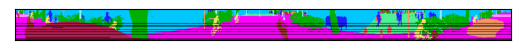

In [25]:
#Predicted Output
import numpy as np
import matplotlib.pyplot as plt

learning_map = {
    0: 0,     # "unlabeled"
    1: 0,     # "outlier" mapped to "unlabeled"
    10: 1,    # "car"
    11: 2,    # "bicycle"
    13: 5,    # "bus" mapped to "other-vehicle"
    15: 3,    # "motorcycle"
    16: 5,    # "on-rails" mapped to "other-vehicle"
    18: 4,    # "truck"
    20: 5,    # "other-vehicle"
    30: 6,    # "person"
    31: 7,    # "bicyclist"
    32: 8,    # "motorcyclist"
    40: 9,    # "road"
    44: 10,   # "parking"
    48: 11,   # "sidewalk"
    49: 12,   # "other-ground"
    50: 13,   # "building"
    51: 14,   # "fence"
    52: 0,    # "other-structure" mapped to "unlabeled"
    60: 9,    # "lane-marking" to "road"
    70: 15,   # "vegetation"
    71: 16,   # "trunk"
    72: 17,   # "terrain"
    80: 18,   # "pole"
    81: 19,   # "traffic-sign"
    99: 0,    # "other-object" to "unlabeled"
    252: 1,   # "moving-car" to "car"
    253: 7,   # "moving-bicyclist" to "bicyclist"
    254: 6,   # "moving-person" to "person"
    255: 8,   # "moving-motorcyclist" to "motorcyclist"
    256: 5,   # "moving-on-rails" mapped to "other-vehicle"
    257: 5,   # "moving-bus" mapped to "other-vehicle"
    258: 4,   # "moving-truck" to "truck"
    259: 5    # "moving-other-vehicle" to "other-vehicle"
}

# Define the inverse mapping dictionary
learning_map_inv = {
    0: 0,     # "unlabeled"
    1: 0,     # "outlier" mapped to "unlabeled"
    10: 1,    # "car"
    11: 2,    # "bicycle"
    13: 5,    # "bus" mapped to "other-vehicle"
    15: 3,    # "motorcycle"
    16: 5,    # "on-rails" mapped to "other-vehicle"
    18: 4,    # "truck"
    20: 5,    # "other-vehicle"
    30: 6,    # "person"
    31: 7,    # "bicyclist"
    32: 8,    # "motorcyclist"
    40: 9,    # "road"
    44: 10,   # "parking"
    48: 11,   # "sidewalk"
    49: 12,   # "other-ground"
    50: 13,   # "building"
    51: 14,   # "fence"
    52: 0,    # "other-structure" mapped to "unlabeled"
    60: 9,    # "lane-marking" to "road"
    70: 15,   # "vegetation"
    71: 16,   # "trunk"
    72: 17,   # "terrain"
    80: 18,   # "pole"
    81: 19,   # "traffic-sign"
    99: 0,    # "other-object" to "unlabeled"
    252: 1,   # "moving-car" to "car"
    253: 7,   # "moving-bicyclist" to "bicyclist"
    254: 6,   # "moving-person" to "person"
    255: 8,   # "moving-motorcyclist" to "motorcyclist"
    256: 5,   # "moving-on-rails" mapped to "other-vehicle"
    257: 5,   # "moving-bus" mapped to "other-vehicle"
    258: 4,   # "moving-truck" to "truck"
    259: 5    # "moving-other-vehicle" to "other-vehicle"
}

# Define the color mapping dictionary
color_map = {
    0: [0, 0, 0],
    1: [0, 0, 255],
    10: [245, 150, 100],
    11: [245, 230, 100],
    13: [250, 80, 100],
    15: [150, 60, 30],
    16: [255, 0, 0],
    18: [180, 30, 80],
    20: [255, 0, 0],
    30: [30, 30, 255],
    31: [200, 40, 255],
    32: [90, 30, 150],
    40: [255, 0, 255],
    44: [255, 150, 255],
    48: [75, 0, 75],
    49: [75, 0, 175],
    50: [0, 200, 255],
    51: [50, 120, 255],
    52: [0, 150, 255],
    60: [170, 255, 150],
    70: [0, 175, 0],
    71: [0, 60, 135],
    72: [80, 240, 150],
    80: [150, 240, 255],
    81: [0, 0, 255],
    99: [255, 255, 50],
    252: [245, 150, 100],
    256: [255, 0, 0],
    253: [200, 40, 255],
    254: [30, 30, 255],
    255: [90, 30, 150],
    257: [250, 80, 100],
    258: [180, 30, 80],
    259: [255, 0, 0]
}

# Load the NumPy file
file_path = "/DATA2/Vivek/Vivekk/Data/VoxelScape/Voxel_Downstream_Task/Train/train_lidar_label/03_000859.npy"
data = np.load(file_path)

# Define inverse mapping function (assuming keys are unique)
def inverse_map(val):
  for key, value in learning_map.items():
    if value == val:
      return key
  return 0  # Assign unlabeled value if not found

# Apply inverse mapping to the data
data_mapped = np.vectorize(inverse_map)(data)

# Create color image based on color map
color_image = np.empty((data.shape[0], data.shape[1], 3), dtype=np.uint8)
for i in range(data_mapped.shape[0]):
  for j in range(data_mapped.shape[1]):
    color_image[i, j] = color_map[data_mapped[i, j]]

# Display the color image without ticks and border
plt.imshow(color_image, extent=(0, data.shape[1], 0, data.shape[0]))  # Set extent
plt.xticks([])
plt.yticks([])
plt.show()

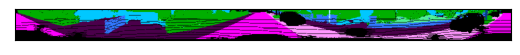

In [28]:
#target
import numpy as np
import matplotlib.pyplot as plt


# Load the NumPy file
file_path = "/DATA2/Vivek/Data/Downstream Task/Test/test_lidar_label/03_000002.npy"
data = np.load(file_path)

# Define inverse mapping function (assuming keys are unique)
def inverse_map(val):
  for key, value in learning_map.items():
    if value == val:
      return key
  return 0  # Assign unlabeled value if not found

# Apply inverse mapping to the data
data_mapped = np.vectorize(inverse_map)(data)

# Create color image based on color map
color_image = np.empty((data.shape[0], data.shape[1], 3), dtype=np.uint8)
for i in range(data_mapped.shape[0]):
  for j in range(data_mapped.shape[1]):
    color_image[i, j] = color_map[data_mapped[i, j]]

# Display the color image without ticks and border
plt.imshow(color_image, extent=(0, data.shape[1], 0, data.shape[0]))  # Set extent
plt.xticks([])
plt.yticks([])
plt.show()

(64, 1024)


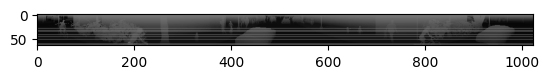

Data values:
 [[ 0.61219656  0.6123923   0.6128005  ...  0.61098206  0.6113018
   0.61164343]
 [ 0.3351072   0.3352114   0.33542883 ...  0.3344592   0.33462846
   0.33480966]
 [ 0.19663036  0.19668901  0.19681108 ...  0.19627273  0.19636667
   0.19646752]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.9636306  -1.9636331  -1.9636378  ... -1.9636095  -1.9636161
  -1.9636223 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Data range: -2.1288056 to 2.318141


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Load the label file
file_path = "/DATA2/Vivek/Vivekk/Data/VoxelScape/Voxel_Downstream_Task/Train/train_lidar_z/03_000668.npy"
data = np.load(file_path)
print(data.shape)

# Plot the 2D data as a grayscale image
plt.imshow(data, cmap='gray')
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
plt.show()

print("Data values:\n", data)

# Calculate and print the data range
data_min = np.min(data)
data_max = np.max(data)
print(f"Data range: {data_min} to {data_max}")
